In [4]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import nibabel as nb
import random
import splitfolders
import os
from sklearn.preprocessing import MinMaxScaler
import glob

# DATA PREPARATION


In [2]:
train_data_path = "./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [3]:
test_image_flair = nb.load(train_data_path+"BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
test_image_seg = nb.load(train_data_path+"BraTS20_Training_355/BraTS20_Training_355_seg.nii").get_fdata()
test_image_t1 = nb.load(train_data_path+"BraTS20_Training_355/BraTS20_Training_355_t1ce.nii").get_fdata()
test_image_t2 = nb.load(train_data_path+"BraTS20_Training_355/BraTS20_Training_355_t2.nii").get_fdata()

scaler = MinMaxScaler()

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)


In [4]:
# Testing scale
print("The minimum value is: ",test_image_flair.min())
print("The maximum value is: ",test_image_flair.max())

The minimum value is:  0.0
The maximum value is:  1.0


In [5]:
test_image_flair.shape

(240, 240, 155)

In [6]:
# Mask Labels
np.unique(test_image_seg)

array([0., 1., 2., 4.])

In [7]:
# Converting to int
test_image_seg = test_image_seg.astype(np.uint8)
np.unique(test_image_seg)

array([0, 1, 2, 4], dtype=uint8)

In [8]:
# reassigning value 4 to 3, because there is no label 3 in data
test_image_seg[test_image_seg == 4] = 3
np.unique(test_image_seg)

array([0, 1, 2, 3], dtype=uint8)

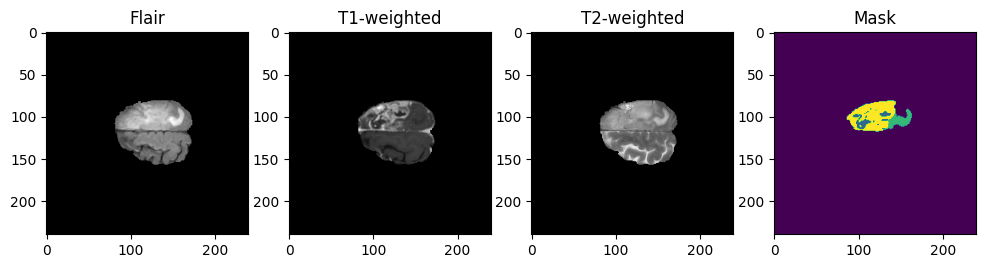

In [9]:
# Random value (dim)
slice = random.randint(0, test_image_seg.shape[2])

# Figure
plt.figure(figsize=(12,8))

# Flair image
plt.subplot(141)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title("Flair")

# T1-weighted image
plt.subplot(142)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title("T1-weighted")

# T2-weighted image
plt.subplot(143)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title("T2-weighted")

# Mask image
plt.subplot(144)
plt.imshow(test_image_seg[:,:,slice])
plt.title("Mask")

plt.show()

## Combining 3 images by exploring to channels and Cropping

3 images T1,T2,Flair are going to be combined since thay have more informative

In [11]:
combined = np.stack([test_image_flair,test_image_t2,test_image_t1],axis=3)    
combined.shape

(240, 240, 155, 3)

In [12]:
# Cropping image

# Crop combined
combined_cropped = combined[56:184,56:184,13:141]  

# Crop MASK
mask_cropped = test_image_seg[56:184,56:184,13:141] 

In [13]:
print("Cropped shape of combined image: ", combined_cropped.shape)
print("Cropped shape of mask image: ", mask_cropped.shape)

Cropped shape of combined image:  (128, 128, 128, 3)
Cropped shape of mask image:  (128, 128, 128)


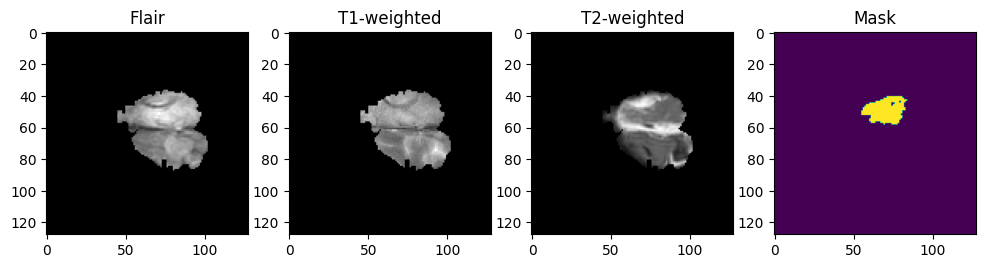

In [14]:
# Random value (dim)
slice = random.randint(0, test_image_seg.shape[2])

# Figure
plt.figure(figsize=(12,8))

# Flair image
plt.subplot(141)
plt.imshow(combined_cropped[:,:,slice,0], cmap='gray')
plt.title("Flair")

# T1-weighted image
plt.subplot(142)
plt.imshow(combined_cropped[:,:,slice,1], cmap='gray')
plt.title("T1-weighted")

# T2-weighted image
plt.subplot(143)
plt.imshow(combined_cropped[:,:,slice,2], cmap='gray')
plt.title("T2-weighted")

# Mask image
plt.subplot(144)
plt.imshow(mask_cropped[:,:,slice])
plt.title("Mask")

plt.show()

I have done so far with one image, now, it is time to apply what I did for each images in dataset

In [16]:
t2_list = sorted(glob.glob('./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1_list = sorted(glob.glob('./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

In [17]:
print('Number of files: ',len(t2_list))
print(t2_list[0])
print(t1_list[0])
print(flair_list[0])
print(mask_list[0])

Number of files:  369
./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t2.nii
./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_t1ce.nii
./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_flair.nii
./data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData\BraTS20_Training_001\BraTS20_Training_001_seg.nii


To run the following cell create 2 directories for images and masks
The directory should be migth look somehow like "./data/BraTS2020_TrainingData/Input/images" for images and "./data/BraTS2020_TrainingData/Input/masks" for masks

In [18]:
n = len(t2_list)

for img in range(n):
    flair_img = nb.load(flair_list[img]).get_fdata()
    t1_img = nb.load(t1_list[img]).get_fdata()
    t2_img = nb.load(t2_list[img]).get_fdata()
    mask_img = nb.load(mask_list[img]).get_fdata()

    flair_img = scaler.fit_transform(flair_img.reshape(-1, flair_img.shape[-1])).reshape(flair_img.shape)
    t1_img = scaler.fit_transform(t1_img.reshape(-1, t1_img.shape[-1])).reshape(t1_img.shape)
    t2_img = scaler.fit_transform(t2_img.reshape(-1, t2_img.shape[-1])).reshape(t2_img.shape)

    mask_img = mask_img.astype(np.uint8)

    mask_img[mask_img == 4] = 3

    combined = np.stack([flair_img,t1_img,t2_img],axis=3)  

    # Crop combined
    combined_cropped = combined[56:184,56:184,13:141]  

    # Crop MASK
    mask_cropped = test_image_seg[56:184,56:184,13:141] 

    val, counts = np.unique(mask_cropped, return_counts=True)

    if (1-(counts[0]/counts.sum())) > 0.01:
        mask_cropped = to_categorical(mask_cropped, num_classes=4)
        np.save('./data/BraTS2020_TrainingData/Input/images/image_' + str(img) + '.npy', combined_cropped)
        np.save('./data/BraTS2020_TrainingData/Input/masks/mask_' + str(img) + '.npy', mask_cropped)

Splitting Folders to Train and Val Data

In [21]:
input_folder = "./data/BraTS2020_TrainingData/Input/"
output_folder = "./data/BraTS2020_TrainingData/Output/"

splitfolders.ratio(input_folder,output=output_folder, seed=42,ratio=(.75,.25),group_prefix=None)

# CUSTOM DATA GENERATOR

In [16]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

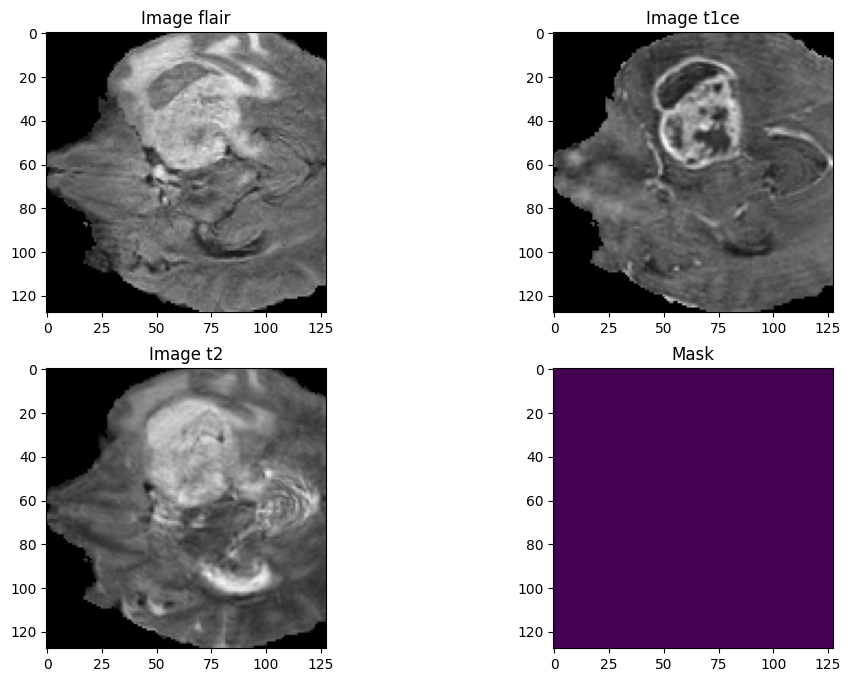

In [19]:
train_img_dir = "./data/BraTS2020_TrainingData/Output/train/images/"
train_mask_dir = "./data/BraTS2020_TrainingData/Output/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

batch_size = 2